In [1]:
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using Parameters
using StaticArrays
using ProfileView

using GridInterpolations 
using POMDPs
using POMDPToolbox
using QMDP
using JLD
using Reel
using Revise


include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/helpers.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


animate_record (generic function with 2 methods)

In [68]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/helpers.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


qmdp_policy = load("policy.jld")["policy"];


pomdp = SingleOCFPOMDP()
updater = SingleOCFUpdater(pomdp)

params = CrosswalkParams()
params.obstacles_visible = false

obstacle_1 = ConvexPolygon([VecE2(34, -1.5), VecE2(34, -4.5), VecE2(46.5, -4.5), VecE2(46.5, -1.5)],4)
obstacle_2 = ConvexPolygon([VecE2(34, +4.5), VecE2(34, +7.5), VecE2(46.5, +7.5), VecE2(46.5, +4.5)],4)
params.obstacles = [obstacle_1, obstacle_2]
#params.obstacles = [obstacle_2]

env = CrosswalkEnv(params)
pomdp.env = env



ego_v = 11.11
ped_v = 5.4/3.6
hitpoint = 0             # 50: middle, 100: left corner, 0: right corner
ped_theta = π/2


# fix values
ped_x = 50.0
ped_y_start = -5.0
ego_y = 0.0


ped_y_offset_hitpoint = VehicleDef().width * hitpoint / 100 - VehicleDef().width/2
ped_y_end = ped_y_offset_hitpoint
ped_t_collision = (ped_y_end - ped_y_start) / ped_v; 
ego_x = ped_x - ego_v * ped_t_collision - VehicleDef().length/2;

if ( false )
    ego_v = 0.0
    ego_x = 20
    ped_x = 30
    ped_y_start = -2.0
    ped_v = 0.0
end

#ped_y_start = -5.0
#ped_v = 1.0

# Car definition
ego_initial_state = VehicleState(VecSE2(ego_x, ego_y, 0.), env.roadway.segments[1].lanes[1], env.roadway, ego_v)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = VehicleState(VecSE2(ped_x,ped_y_start,ped_theta), env.crosswalk, env.roadway, ped_v)
ped = Vehicle(ped_initial_state, AutomotivePOMDPs.PEDESTRIAN_DEF, 2)

scene = Scene()
push!(scene, ego)
push!(scene, ped)



cam = FitToContentCamera(0.);
timestep = 0.2


pos_noise = 0.001
vel_noise = 0.001
false_positive_rate = 0.00
false_negative_rate = 0.00
rng = MersenneTwister(1);
sensor = AutomotiveSensors.GaussianSensor(AutomotiveSensors.LinearNoise(10, pos_noise, 0.00), 
                 AutomotiveSensors.LinearNoise(10, vel_noise, 0.00), false_positive_rate, false_negative_rate, rng) 



# define a model for each entities present in the scene
models = Dict{Int, DriverModel}()

ego_id = 1
ped_id = 2

obs = SingleOCFState(0.0, ego_v, ped_x-ego_x, ped_y_start, ped_theta, ped_v)
println(obs)

pomdp.ego_vehicle = ego
models[ego_id] = FrenetPedestrianPOMDP(a=LatLonAccel(0.0, 0.0),env=env,sensor=sensor, obstacles=env.obstacles, timestep=timestep,
    env=env,
    pomdp=pomdp,
    policy=qmdp_policy,
    updater=updater,
    ego_vehicle=ego,
    desired_velocity=ego_v,
    b=initBeliefAbsentPedestrian(pomdp, ego_y, ego_v)
)
models[ego_id].pomdp.desired_velocity = ego_v
models[ego_id].pomdp.ΔT = timestep

models[ped_id] = ConstantPedestrian(v_desired=ped_v, dawdling_amp=0.001) # dumb model

nticks = 25
rec = SceneRecord(nticks+1, timestep)

risk = Float64[]
sensor_observations = [Vehicle[]]
belief = SingleOCFBelief[]
ego_vehicle = Vehicle[]
action_pomdp = SingleOCFAction[]

obs_callback = (ObservationCallback(risk,sensor_observations, belief, ego_vehicle, action_pomdp),)

tic()
simulate!(rec, scene, env.roadway, models, nticks, obs_callback)
toc()




SingleOCFState(0.0, 11.11, 32.36733333333333, -5.0, 1.5707963267948966, 1.5)
--------------------------POMDP high level planner----------------------- t: 0.0
EGO: x/y:17.632666666666672 / 0.0 v: 11.11
PED: x/y: 50.00038239596779 / -5.000597634476728 v: 1.4999895547553626
delta_s: 32.36771572930112 delta_t: -5.000597634476728
Observation cont: SingleOCFState(0.0, 11.11, 32.36771572930112, -5.000597634476728, 1.5707963267948966, 1.4999895547553626)
init belief absent
action before update: SingleOCFAction(0.0, 0.0)
Pedestrian is absent: SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)
ego_v_state_space: 11.0
b-length: 1
action after update: SingleOCFAction(-1.0, 0.0)
--------------------------POMDP high level planner----------------------- t: 0.2
EGO: x/y:19.834666666666674 / 0.0 v: 10.91
PED: x/y: 50.00056391137899 / -4.69770491217616 v: 1.4977329136511994
delta_s: 30.16589724471231 delta_t: -4.69770491217616
Observation cont: SingleOCFState(0.0, 10.91, 30.16589724471231, -4.69770491217

EGO: x/y:41.982666666666674 / 0.0 v: 4.509999999999999
PED: x/y: 50.00301324372614 / 0.1990364560401791 v: 1.4986148919323241
delta_s: 8.020346577059463 delta_t: 0.1990364560401791
Observation cont: SingleOCFState(0.0, 4.509999999999999, 8.020346577059463, 0.1990364560401791, 1.5707963267948966, 1.4986148919323241)
action before update: SingleOCFAction(-4.0, 0.0)
Pedestrian is visible: SingleOCFState(0.0, 4.509999999999999, 8.020346577059463, 0.1990364560401791, 1.5707963267948966, 1.4986148919323241)
ego_v_state_space: 5.0
b-length: 17
action after update: SingleOCFAction(-4.0, 0.0)
--------------------------POMDP high level planner----------------------- t: 3.2000000000000006
EGO: x/y:42.80466666666668 / 0.0 v: 3.709999999999999
PED: x/y: 50.00190484125926 / 0.4982800106436838 v: 1.0003207692799874
delta_s: 7.197238174592584 delta_t: 0.4982800106436838
Observation cont: SingleOCFState(0.0, 3.709999999999999, 7.197238174592584, 0.4982800106436838, 1.5707963267948966, 1.000320769279987

14.490699437

In [69]:
duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, CarFollowCamera(2,10.0))
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp9hoNAW", 0x000000000000001a, 5.0, nothing)

In [4]:
n_states(pomdp)

107251

In [32]:
bel = belief[7]
for b in bel
    println(b)
end

length(bel)

SingleOCFState(0.0, 9.0, 18.0, -5.0, 0.785, 0.0)=>3.568543127849587e-11
SingleOCFState(0.0, 9.0, 20.0, -5.0, 0.785, 0.0)=>7.860541950739214e-7
SingleOCFState(0.0, 9.0, 22.0, -5.0, 0.785, 0.0)=>6.666368327458067e-7
SingleOCFState(0.0, 9.0, 24.0, -5.0, 0.785, 0.0)=>3.026364526767468e-11
SingleOCFState(0.0, 9.0, 18.0, -5.0, 1.0466666666666666, 0.0)=>8.401422917220955e-11
SingleOCFState(0.0, 9.0, 20.0, -5.0, 1.0466666666666666, 0.0)=>1.8506077948541641e-6
SingleOCFState(0.0, 9.0, 22.0, -5.0, 1.0466666666666666, 0.0)=>1.569463437441822e-6
SingleOCFState(0.0, 9.0, 24.0, -5.0, 1.0466666666666666, 0.0)=>7.124971558455116e-11
SingleOCFState(0.0, 9.0, 18.0, -5.0, 1.3083333333333333, 0.0)=>1.4047586858414953e-10
SingleOCFState(0.0, 9.0, 20.0, -5.0, 1.3083333333333333, 0.0)=>3.0943060473466666e-6
SingleOCFState(0.0, 9.0, 22.0, -5.0, 1.3083333333333333, 0.0)=>2.6242190371560727e-6
SingleOCFState(0.0, 9.0, 24.0, -5.0, 1.3083333333333333, 0.0)=>1.1913298237370718e-10
SingleOCFState(0.0, 9.0, 18.0, -5

SingleOCFState(0.0, 9.0, 20.0, -5.0, 2.0933333333333333, 1.5)=>0.021901409430766083
SingleOCFState(0.0, 9.0, 22.0, -5.0, 2.0933333333333333, 1.5)=>0.018574147058934037
SingleOCFState(0.0, 9.0, 24.0, -5.0, 2.0933333333333333, 1.5)=>8.432198314423826e-7
SingleOCFState(0.0, 9.0, 18.0, -5.0, 2.355, 1.5)=>4.233608568756033e-7
SingleOCFState(0.0, 9.0, 20.0, -5.0, 2.355, 1.5)=>0.009325502471303879
SingleOCFState(0.0, 9.0, 22.0, -5.0, 2.355, 1.5)=>0.00790877202894208
SingleOCFState(0.0, 9.0, 24.0, -5.0, 2.355, 1.5)=>3.590384740683479e-7
SingleOCFState(0.0, 9.0, 18.0, -5.0, 0.785, 2.0)=>7.860239314287163e-7
SingleOCFState(0.0, 9.0, 20.0, -5.0, 0.785, 2.0)=>0.01731399584066008
SingleOCFState(0.0, 9.0, 22.0, -5.0, 0.785, 2.0)=>0.014683653394033812
SingleOCFState(0.0, 9.0, 24.0, -5.0, 0.785, 2.0)=>6.666011473146018e-7
SingleOCFState(0.0, 9.0, 18.0, -5.0, 1.0466666666666666, 2.0)=>1.8505365451387258e-6
SingleOCFState(0.0, 9.0, 20.0, -5.0, 1.0466666666666666, 2.0)=>0.040762349292957974
SingleOCFStat

140

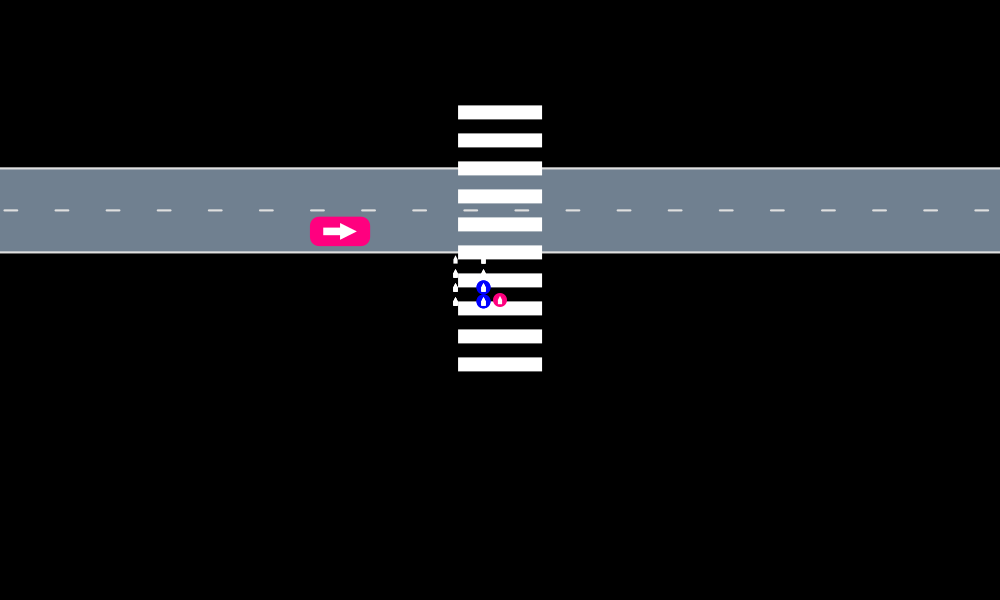

In [71]:
i = 3
scene = rec[0]
bel = belief[i]
belief_overlay = BeliefOverlay(belief=bel, ego_vehicle=ego_vehicle[i])

AutoViz.render(rec[-1], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

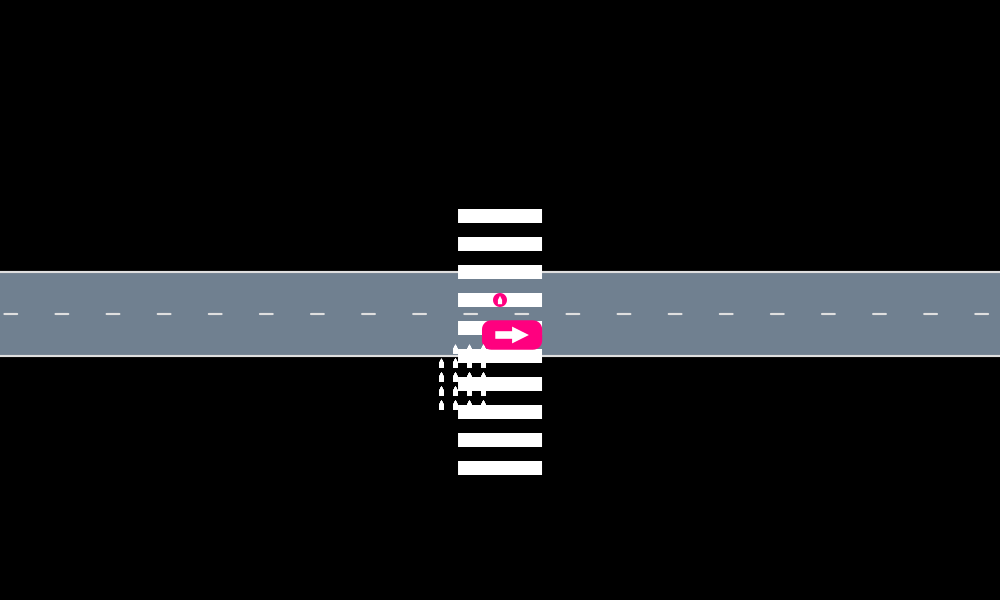

In [31]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/helpers.jl")


include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")

next_states = SingleOCFState[]
for (s, prob) in weighted_iterator(bel)
    td = transition(pomdp, s, SingleOCFAction(-2.0, 0.0), pomdp.ΔT)
    for sp in td.vals
        push!(next_states, sp)
    end
end
pred_bel = SparseCat(next_states, normalize(ones(length(next_states)),1))
belief_overlay = BeliefOverlay(belief=pred_bel, ego_vehicle=ego_vehicle[i])
fake_ego = VehicleState()
scene = Scene()
AutoViz.render(rec[0], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

In [46]:
pomdp

SingleOCFPOMDP
  env: AutomotivePOMDPs.CrosswalkEnv
  ego_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  longitudinal_actions: Array{Float64}((5,)) [1.0, 0.0, -1.0, -2.0, -4.0]
  lateral_actions: Array{Float64}((3,)) [1.0, 0.0, -1.0]
  ΔT: Float64 0.5
  PED_A_RANGE: Array{Float64}((5,)) [-2.0, -1.0, 0.0, 1.0, 2.0]
  PED_THETA_NOISE: Array{Float64}((3,)) [-0.195, 0.0, 0.195]
  PED_SAFETY_DISTANCE: Float64 1.0
  EGO_Y_MIN: Float64 -1.0
  EGO_Y_MAX: Float64 1.0
  EGO_Y_RANGE: Array{Float64}((1,)) [0.0]
  EGO_V_MIN: Float64 0.0
  EGO_V_MAX: Float64 14.0
  EGO_V_RANGE: Array{Float64}((29,)) [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0]
  S_MIN: Float64 0.0
  S_MAX: Float64 50.0
  S_RANGE: Array{Float64}((51,)) [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]
  T_MIN: Float64 -5.0
  T_MAX: Float64 5.0
  T_RANGE: Array{F

In [55]:
pomdp.env.params.obstacles_visible

false

is_observation_absent (generic function with 1 method)

SingleOCFState(-1.0, 14.0, -10.0, -10.0, 0.0, 0.0)

In [119]:
s = SingleOCFState(0.0, 10.5, -10.0, -10.0, 0.0, 0.0)
a = SingleOCFAction(-4.0, 0.0)
td = transition(pomdp, s, a) 


absent_state_present = false
for (s, prob) in weighted_iterator(td)
    if is_state_absent(pomdp, s) 
       absent_state_present = true 
    end
    cnt += 1
end


SingleOCFState(0.0, 9.5, -10.0, -10.0, 0.0, 0.0)


LoadError: [91msyntax: unexpected "end"[39m

In [191]:
b = POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 9.0, -10.0, -10.0, 0.0, 0.0)], [1.0])
a = SingleOCFAction(-4.0, 0.0)
o = SingleOCFState(0.0, 8.329999999999998, 21.32259231837015, -4.899329938018746, 1.5707963267948966, 2.5005508523775006)

(ego_y_state_space, ego_v_state_space) = getEgoDataInStateSpace(pomdp, o.ego_y, o.ego_v)

sp = get_state_absent(pomdp, ego_y_state_space, ego_v_state_space)
sp = SingleOCFState(0.0, 0.0, 21.0, -5.0, 1.57, 2)
po = observation_weight(pomdp, sp, o) 


0.040455258340222476

0.040455258340222476

In [228]:
length(bel)

136

In [36]:
n_states(pomdp)

1451451